In [3]:
options(repr.plot.width=8, repr.plot.height=4)



# R and Stan

----

### Mathew Hall


# Example 

(Shamefully stolen from Krushke)

<img src="coin.jpg">

Suppose you are given a coin. Let's pretend the coin has a fixed bias set by the factory that produced it

1. How can we model this process?
2. How can we fit a model of the process to the data we have?
3. Given the above, what can we say about the coin?


Image credit: hom26 on Flickr CC BY-NC-ND 2.0

# Modelling a coin flip with a bias


In [4]:
# Simulate a coin flip:
flip <- function(n,p) {
    sample(c('H','T'), p=c(p,1-p),size = n,replace=T)
}

flip(10,0.5)

[1] "T" "T" "T" "H" "T" "H" "T" "T" "H" "H"

In [5]:
table(flip(1000,0.5))


  H   T 
542 458 

In [6]:
heads <- function(n,p) {
    sum(flip(n,p) == 'H')
}

heads(1000,0.5)

[1] 532

# Simulating Coins

We now have the means to simulate a coin. Assuming that our simulation is identical to the real world (i.e. when a coin flips it samples from the outcomes independently using one fixed probability), we're close to describing the coin exactly.

But we have a parameter (`p`); what value should we use?

What we're asking for are *values of parameters of the model*. 

If we know what number `p` the coin is using we can say whether it's fair or not. We can also simulate the coin cheaply.


# Guessing `p`

Suppose we have a coin, and we observe $15$ heads in $50$ flips. What should be our guess of the bias for the coin?

We could guess `p` by creating a lot of coins with different biases and see which one best fits the data we got (gets closest to 15).

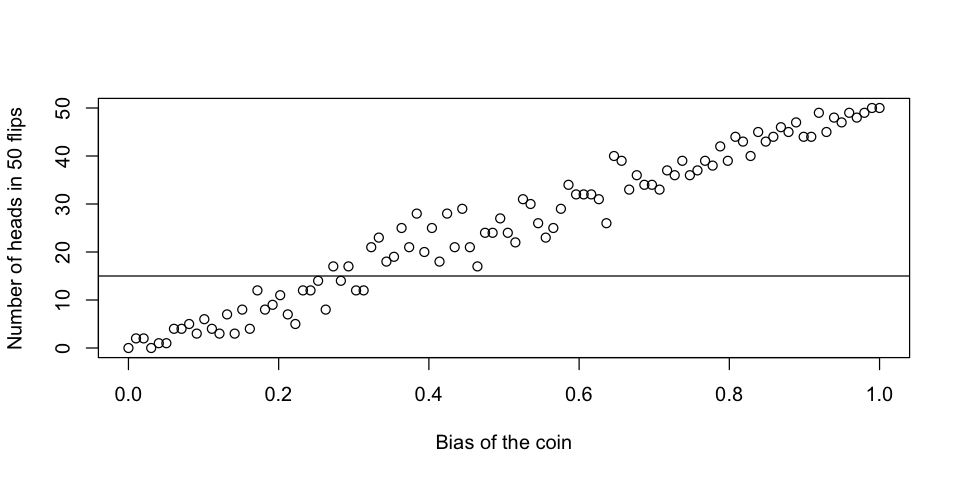

In [17]:
bias <- seq(0,1,length.out = 100)
plot(
    bias,
    sapply(
        bias, 
        function(x)heads(50,x)
        ), 
    ylab="Number of heads in 50 flips", 
    xlab="Bias of the coin")
abline(h=15)

This doesn't work too well.

Suppose we flipped the coin 50 times and repeated it 10,000 times. How many heads would we see?

In [24]:
# This isn't the model we're building,
# this is the "real" coin which turns out
# to have a fixed bias.

# We're using this to simulate what happens
# when we experiment with the real coin.

p <- 0.3 #Secret bias of the coin
coin <- function(n)heads(n,p)
coin(50)

[1] 15

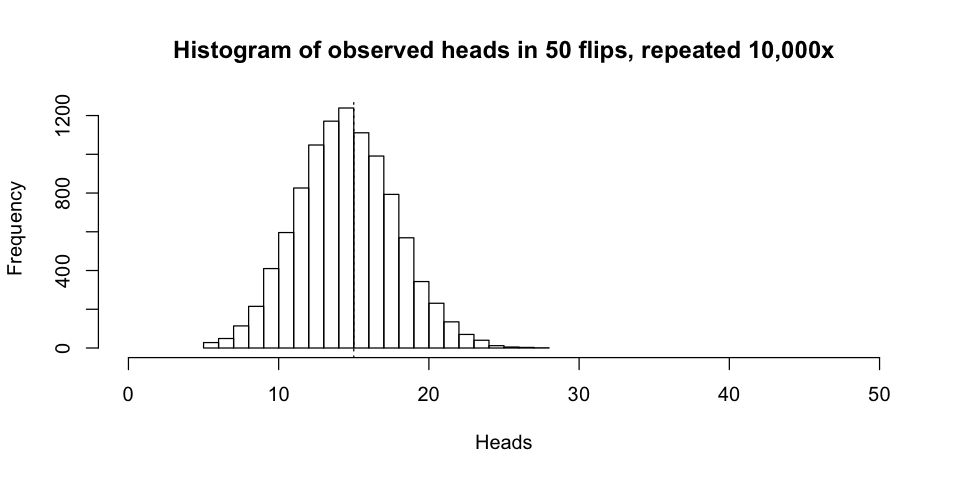

In [127]:
hist(replicate(10000, coin(50)),
     breaks = 30, 
     xlim=c(0,50),
     xlab="Heads",
     main="Histogram of observed heads in 50 flips, repeated 10,000x")
abline(v = 15, lty=3)

When you flip the coin 50 times, you don't always get 15 heads. It's the most likely outcome, but lots of other outcomes are only a bit less likely.

Even if you flip the coin 10000 times instead of 50 there's still variability.

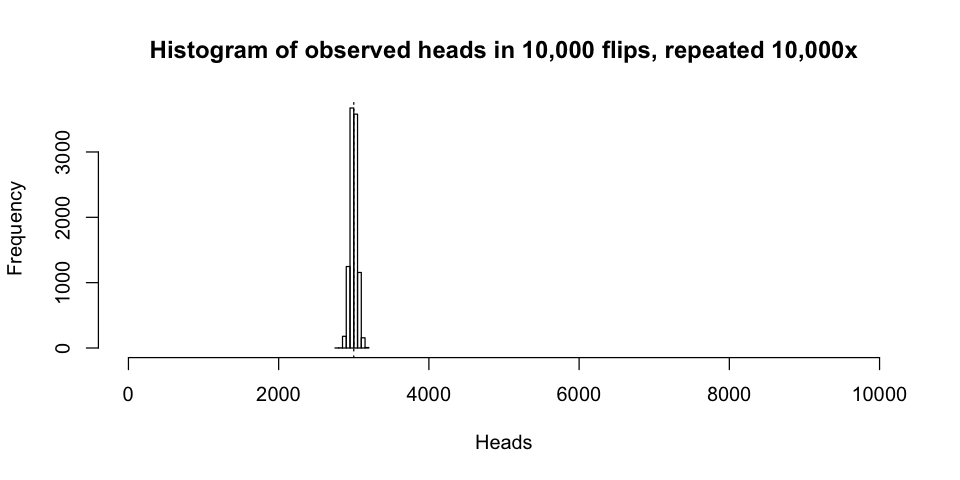

In [166]:
hist(replicate(10000, coin(10000)),
     breaks = 12, 
     xlim=c(0,10000),
     xlab="Heads",
     main="Histogram of observed heads in 10,000 flips, repeated 10,000x")
abline(v = 0.3 * 10000, lty=3)

# Randomness

If we saw 16 or 14 heads in those 50 flips, we'd reach a slightly different conclusion.

We can't control this randomness.

We can always get more data, but that's expensive.

If we can't reduce the variation to a tiny number, we're just going to have to live with it.

Instead of saying what single value $p$ is, let's **offer to give a distribution for it instead.**

# Incorporating Belief

We can characterise what we think a parameter for this model might be as a distribution.

If a coin is probably fair, its bias is $0.5$.

But we should be quite vague about it, I'll assign 95% of my belief to the value being roughly between 0.2 and 0.8.

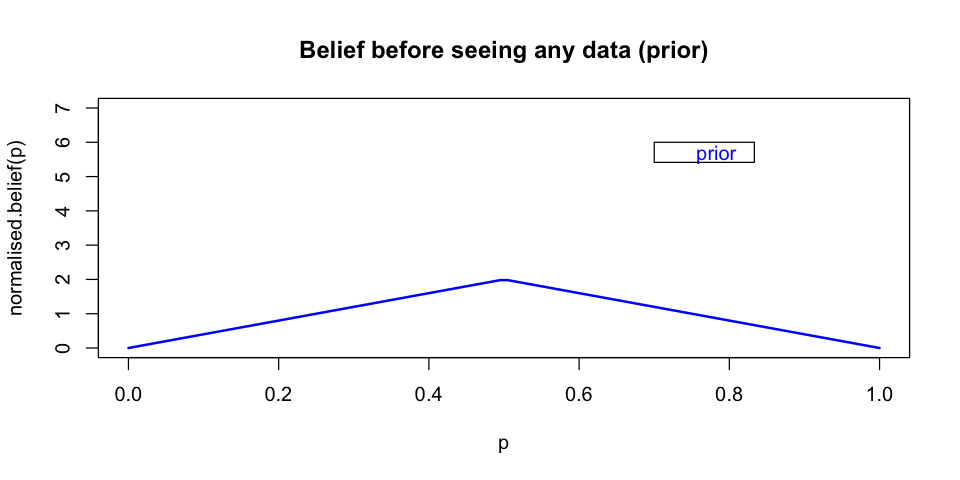

In [117]:
belief <- function(p){0.5-abs(p -0.5)}

normalised.belief <- function(p)belief(p)/(integrate(belief,lower=0,upper=1)$value)

p <- seq(0,1,length.out=100)
plot(p, normalised.belief(p), lwd=2, type='l', col='blue',ylim=c(0,7), main="Belief before seeing any data (prior)")
legend(0.7,6,legend = c("prior"), text.col = c("blue"))



The plot above describes my belief for the fairness of a coin. I think it's most likely that p = 0.5, but there's a lot of credibility assigned to the other values.

That's not the only information we have available to us though. We have a model for coin flips that's built on a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).

One nice property about the binomial function is that we can calculate the probability of a particular outcome happening. For example, instead of simulating flipping 50 coins, we can directly compute the probability of seeing each outcome.


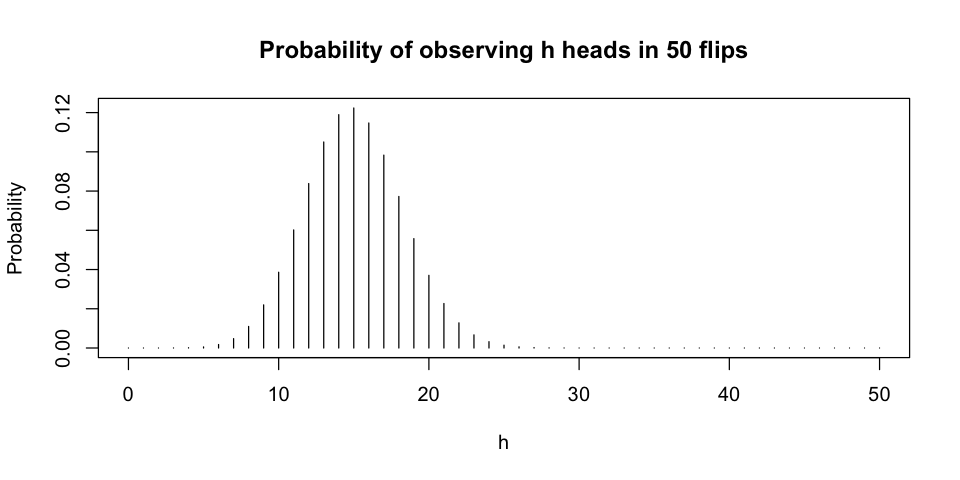

In [59]:
h <- 0:50
plot(h, dbinom(h,size = 50,prob = 0.3), main="Probability of observing h heads in 50 flips",type='h',ylab="Probability")

So in this example, if $p = 0.3$ then we can compute the probability of seeing exactly $15$ heads:

In [63]:
dbinom(15,50,prob=0.3)

[1] 0.12235

What we can also do is *fix the observed values* and see how the density changes when we *change the underlying probability parameter* of the distribution.

Instead of asking how likely each different outcome, we're asking how likely this outcome is for each possible value of $p$.

This allows us to see what the most likely value of $p$ is for the data we observed. This function assigns a likelihood to each parameter value. For this reason, we'll call it the likelihood function.

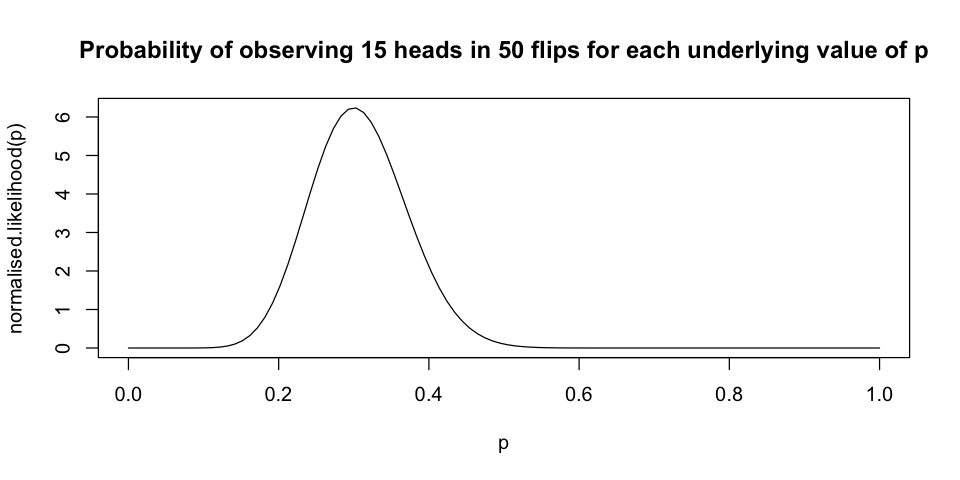

In [110]:
likelihood <- function(p){dbinom(15,50,p)}
                          
normalised.likelihood <- function(p){likelihood(p)/integrate(likelihood,lower = 0,upper=1)$value}

p <- seq(0,1,length.out=100)                          
plot(p, normalised.likelihood(p), type='l',main="Probability of observing 15 heads in 50 flips for each underlying value of p")

# Combining belief and the model

We've described how we believe a normal coin will be parameterised and related the model we have to the data we collected about the coin.

That has given us two curves. In the classic frequentist view we would ignore the first and use the second to talk about the coin. What if we want to combine these separate pieces of evidence?

We can *multiply them* to give a relative weighting to each possible outcome according to both the likelihood and our belief.

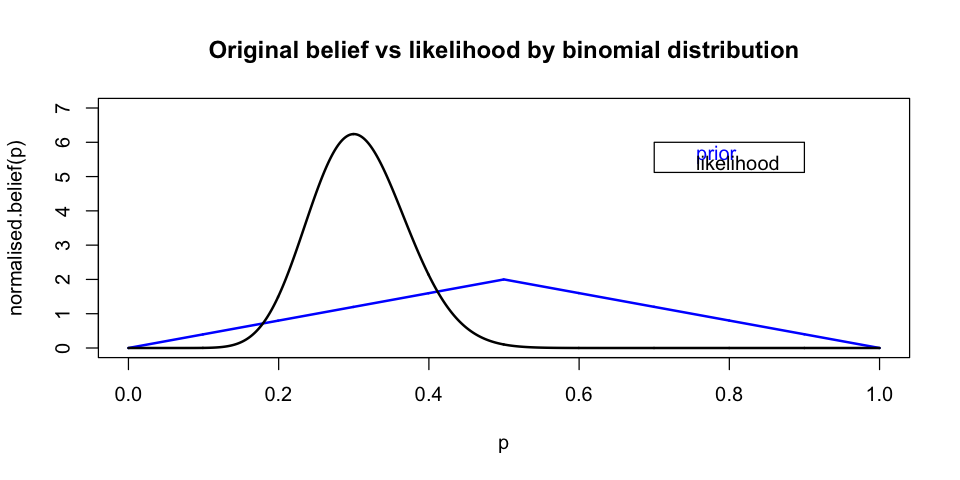

In [111]:

p <- seq(0,1,length.out=1000)
plot(p, normalised.belief(p), lwd=2, type='l', col='blue',ylim=c(0,7), main="Original belief vs likelihood by binomial distribution")
lines(p,normalised.likelihood(p), type='l',lwd=2,xlab="Bias",ylab="Likelihood")

legend(0.7,6,legend = c("prior","likelihood"), text.col = c("blue","black"))


If we multiply the prior and the likelihood, we get a new function. We'll call it the posterior.

[1] 314

[1] 0.31331

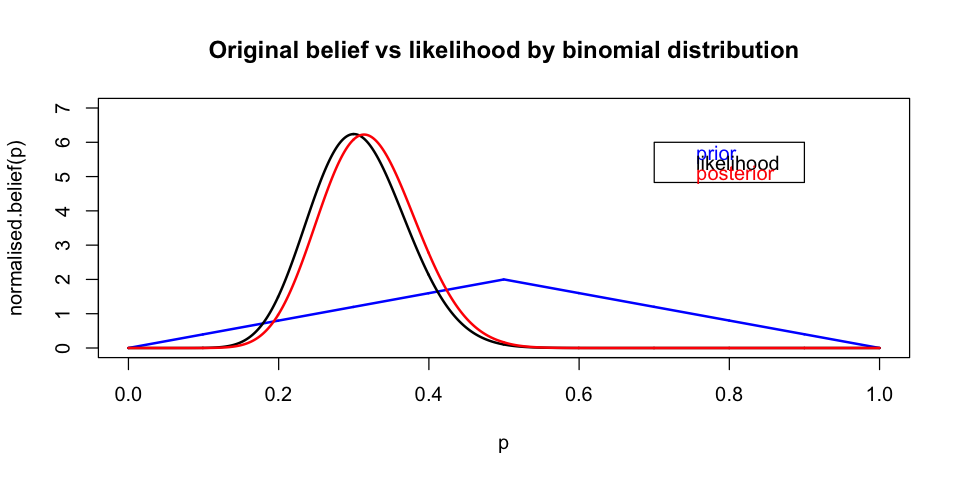

In [123]:
posterior <- function(p)normalised.belief(p) * normalised.likelihood(p)

normalised.posterior <- function(p)posterior(p)/integrate(posterior,lower=0,upper=1)$value

p <- seq(0,1,length.out=1000)
plot(p, normalised.belief(p), lwd=2, type='l', col='blue',ylim=c(0,7), main="Original belief vs likelihood by binomial distribution")
lines(p,normalised.likelihood(p), type='l',lwd=2,xlab="Bias",ylab="Likelihood")
lines(p,normalised.posterior(p),lwd=2, col='red')
legend(0.7,6,legend = c("prior","likelihood","posterior"), text.col = c("blue","black","red"))



# Neat!

This is how Bayesian inference works.

Build a model

Identify parameters and set priors

Compute likelihood

Obtain posterior distribution\*

** this is hard to do in the general case.*

# How Stan Works

Define a model (structure, priors, likelihood)

Provide data

Generate samples from it

Use the samples to say things about the model

In [126]:
library("rstan")

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.14.1, packaged: 2016-12-28 14:55:41 UTC, GitRev: 5fa1e80eb817)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [145]:
model <- "
functions{
    real custom_prior_lpdf(real p){
        return log((0.5-fabs(p - 0.5)/0.25));
    }
}
data {
  int h;
  int N;
}
parameters {
  real<lower=0,upper=1> p;
}
model {
  p ~ custom_prior_lpdf();
  h ~ binomial(N,p);
}"
model.file <- "model.stan"
writeLines(model, con=model.file)

This is a Stan model definition.

Stan will compile it to C++ code and then compile that to machine code.

In this example I defined the prior by creating a function. In practice, it's easier to use a built-in distribution instead of defining one. It's easy to transform off-the-shelf distributions

In [146]:
data <- list(N = 50, h=15)

fit <- stan(file = model.file, data = data, 
            iter = 1000, chains = 4)



In file included from filebf6b7d8eb504.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /Library/Frameworks/R.framework/Versions/3.3/Resources/library/BH/include/boost/math/tools/config.hpp:13:
In file included from 

Warning message:
“There were 554 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [147]:
print(fit)


Inference for Stan model: model.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
p      0.44    0.00 0.03   0.39   0.41   0.43   0.46   0.51   703    1
lp__ -35.60    0.02 0.56 -37.32 -35.72 -35.39 -35.25 -35.20   923    1

Samples were drawn using NUTS(diag_e) at Wed Nov 22 11:16:36 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [140]:
source("~/GDrive/Projects/DBDA/lib/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



Loading required package: coda

Attaching package: ‘coda’

The following object is masked from ‘package:rstan’:

    traceplot

Linked to JAGS 4.2.0
Loaded modules: basemod,bugs

Attaching package: ‘runjags’

The following object is masked from ‘package:rstan’:

    extract



In [141]:
codaSamples = mcmc.list( lapply( 1:ncol(fit) , 
                                   function(x) { mcmc(as.array(fit)[,x,]) } ) )

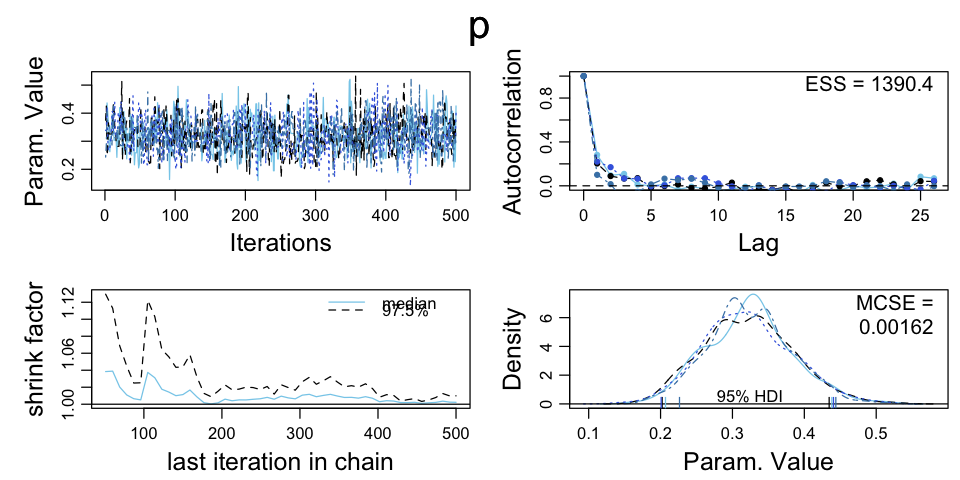

In [142]:
diagMCMC(codaSamples,parName = 'p')

# Summary

Bayesian analysis can be used to combine more than one source of information about a parameter value

Modelling is still about estimating parameters, but the *distribution* is important and not just the most likely estimate

Stan can hide some of the difficulty in using Bayesian analysis

Learn more: Krushke: *Doing Bayesian Data Analysis 2nd Edition* gives a tour of frequentist models and their Bayesian equivalents

<img src="customLogo.png">
